In [1]:
# Actor - policy improvements through parameters t
# Critic - q value approximation through parameters w
# Bellman - v value approximation through parameters h as sanity check

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact
from IPython.display import clear_output

In [4]:
S = 6
A = 2

# Link rewards
R = np.zeros([S, S])
R[2, 3] = 1
#R[4, 3] = 1

# hyperparams
gamma = 0.8

In [33]:
def perform_action(s, a):
    sp = s + (a * 2 - 1)
    if sp < 0:
        sp = 0
    if sp > S-1:
        sp = S-1
    return sp

def reward(s, a):
    sp = perform_action(s, a)
    return R[s, sp]

def features_s(s):
    f = np.zeros([S])
    f[s] = 1
    return f

def features(s, a):
    f = np.zeros([S, A])
    f[s, a] = 1.0
    return f

def exp_f_t(s, a, t):
    f = features(s, a)
    return np.exp(np.sum(f * t))

def policy(s, a, t):
    total = np.sum([exp_f_t(s, aa, t) for aa in range(A)])
    return exp_f_t(s, a, t) / total

def transition_prob(s, sp, t):
    if abs(s-sp) > 1:
        return 0
    for aa in range(A):
        s_test = perform_action(s, aa)
        if s_test == sp:
            return policy(s, aa, t)
    return 0.0

def v_approx(s, h):
    f = features_s(s)
    v = np.sum(f * h)
    return v

def q_approx(s, a, t):
    f = features(s, a)
    q = np.sum(f * t)
    return q

def random_variable(shape):
    return np.random.random_sample(shape)

def transition_matrix(t):
    return np.array([[transition_prob(si, sj, t) for sj in range(S)] for si in range(S)])

def visualize_q():
    q_left = [q_approx(ss, 0, t) for ss in range(S)]
    q_right = [q_approx(ss, 1, t) for ss in range(S)]

    fig = plt.plot(range(S), q_left, 'b--', range(S), q_right, 'r--')
    plt.grid()
    
def visualize_policy():
    p_left = [policy(ss, 0, t) for ss in range(S)]
    p_right = [policy(ss, 1, t) for ss in range(S)]

    fig = plt.plot(range(S), p_left, 'b-', range(S), p_right, 'r-')
    plt.grid()
    
# Objective function
def J(t):
    # calculate probability of being in a given state
    T = transition_matrix(t)
    T = T.dot(T.dot(T.dot(T.dot(T))))
    
    start_p = np.full([S], 1.0/S)
    
    d = T.dot(start_p)
    
    expected_r = 0.0
    for ss in range(S):
        for aa in range(A):
            expected_r += d[ss] * policy(ss, aa, t) * reward(ss, aa)
            
    return expected_r

In [9]:
# Solve for bellman values v, compare with v_approx

# Random policy params t

t = random_variable([S, A])

# Transition matrix
T = transition_matrix(t)

print('T matrix:\n\n{}'.format(T))
print('\nT matrix sum over columns: {}'.format(np.sum(T, axis=1)))

# Convert link rewards into node rewards
node_R = np.array([np.sum([R[ss, sp] * T[ss, sp] for sp in range(S)]) for ss in range(S)])
print('\nnode rewards: {}'.format(node_R))

bellman_v = np.linalg.inv((np.identity(S) - gamma * T)).dot(node_R.T)
print('\nbellman values with current policy: {}'.format(np.round(bellman_v, 2)))

T matrix:

[[ 0.41048142  0.58951858  0.          0.          0.          0.        ]
 [ 0.48035043  0.          0.51964957  0.          0.          0.        ]
 [ 0.          0.53599218  0.          0.46400782  0.          0.        ]
 [ 0.          0.          0.54235625  0.          0.45764375  0.        ]
 [ 0.          0.          0.          0.41895992  0.          0.58104008]
 [ 0.          0.          0.          0.          0.55302344  0.44697656]]

T matrix sum over columns: [ 1.  1.  1.  1.  1.  1.]

node rewards: [ 0.          0.          0.46400782  0.          0.          0.        ]

bellman values with current policy: [ 0.33  0.47  0.83  0.44  0.22  0.15]


In [11]:
# Approximate bellman values using current policy

# Parameters for value function approximation
h = random_variable([S])

approximate v: [0.32683665076564372, 0.46524017781491811, 0.82849235188803161, 0.4443804043228457, 0.22106785618829808, 0.1518156715999672]


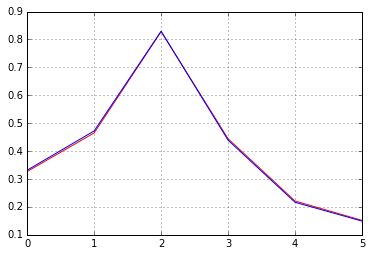

In [18]:
# Run steps to approx bellman values

for run in range(100):
    s = np.random.randint(S)
    
    for step in range(20):
        #a = np.random.choice(range(A), p=[policy(s, aa, t) for aa in range(A)])
        
        sp = np.random.choice(range(S), p=T[s])
        
        r = node_R[s]
        
        delta = (r + gamma * v_approx(sp, h)) - v_approx(s, h)

        h_grad = delta * features_s(s)
        h += 0.01 * h_grad

        s = sp
    
test_v = [v_approx(ss, h) for ss in range(S)]
print('approximate v: {}'.format(test_v))

fig = plt.plot(range(S), test_v, 'r-', range(S), bellman_v, 'b-')
plt.grid()

In [41]:
# initialize parameters for q value func approx and policy approx

t = random_variable([S, A])
w = random_variable([S, A])

objective_steps = []

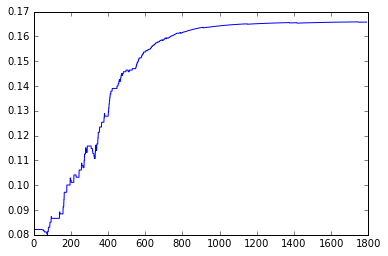

In [47]:
for run in range(10):
    s = 0
    a = np.random.choice(range(A), p=[policy(s, aa, t) for aa in range(A)])
    
    for step in range(30):
        r = reward(s, a)
        sp = perform_action(s, a)

        ap = np.random.choice(range(A), p=[policy(sp, aa, t) for aa in range(A)])

        delta = r + gamma * q_approx(sp, ap, w) - q_approx(s, a, w)

        # Calculate t gradient
        expected_features = np.zeros([S, A])
        for aa in range(A):
            expected_features += policy(s, aa, t) * features(s, aa)

        t_grad = features(s, a) - expected_features

        t = t + 0.1 * t_grad * q_approx(s, a, w)

        w = w + 0.1 * delta * features(s, a)

        a = ap
        s = sp
        
        objective_steps.append(J(t))

        if step % 10 == 0:
            clear_output(wait=True)
            #visualize_q()
            #visualize_policy()
            plt.plot(objective_steps)
            plt.show()

In [26]:
# Typical path

s = 0
a = np.random.choice(range(A), p=[policy(s, aa, t) for aa in range(A)])

for step in range(20):
    
    print(s)
    
    r = reward(s, a)
    
    if r:
        print('Reward!')
    
    sp = perform_action(s, a)
    
    ap = np.random.choice(range(A), p=[policy(sp, aa, t) for aa in range(A)])
    
    a = ap
    s = sp

0
1
2
Reward!
3
2
Reward!
3
2
Reward!
3
2
Reward!
3
2
Reward!
3
2
Reward!
3
2
Reward!
3
2
Reward!
3
2
Reward!
3


In [28]:
np.round(transition_matrix(t), 2)

array([[ 0.25,  0.75,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.12,  0.  ,  0.88,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.01,  0.  ,  0.99,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.99,  0.  ,  0.01,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.76,  0.  ,  0.24],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.67,  0.33]])